Y_Data.shape (1313, 512)
(101, 512)


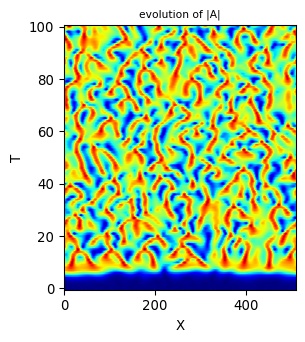

(1313, 512)
ready... Set... GO!
Xtrain shape =  (1247, 50, 512) Ytrain shape =  (1247, 512)
Xval shape =    (16, 50, 512)   Yval shape =    (15, 512)
Xtest shape =   (0, 50, 512)  Ytest shape =   (0, 512)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               975600    
_________________________________________________________________
dense (Dense)                (None, 512)               154112    
Total params: 1,129,712
Trainable params: 1,129,712
Non-trainable params: 0
_________________________________________________________________
None
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_

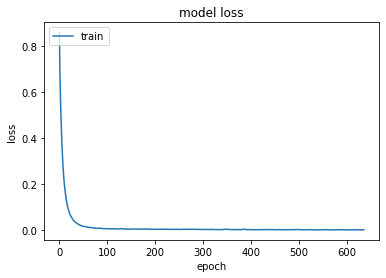

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


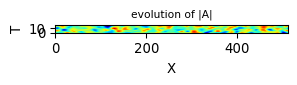

In [1]:
##### %load LSTM.py
#!/usr/bin/env python

# ## LSTM for Lorenz96 
# - simple one layer architecture with X_{lookback-t:t} to X_{t+1}
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import genfromtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import time

# ## Read the raw data
# - 10 million samples from lorenz
# - only 8 X_i variables for t = 1 through 10 million

import mat73

f = mat73.loadmat('Solucion.mat')
#Y_Data = np.array(f['U']) # For converting to a NumPy array

print("Y_Data",f)
print("Y_Data.shape",Y_Data.shape)

y_graph = np.transpose(Y_Data[-101:,:])
y_graph = np.transpose(y_graph)
print(y_graph.shape)


plt.figure(figsize=(300/96,350/96), dpi=96)
plt.imshow(y_graph, aspect='auto', cmap='jet' , origin='lower')
plt.title('evolution of |A|', fontsize=8)
plt.xlabel('X')
plt.ylabel('T')
plt.savefig('puerba1')
plt.show()



# En caso de tener mas de una variable dependiente con diferente escala
mu2, sigma2 = np.mean( Y_Data ), np.std( Y_Data )

Y = (Y_Data - mu2) / sigma2

# Separacion de dataset en training y testing

#Formo 16 cuadrados de 32*32 para tener mas datos para entrenar
#xTrain = np.reshape( np.array( np.split( xTrain, 512/64, axis=1)), (-1, 64) )
#yTrain = np.reshape( np.array( np.split( yTrain, 512/64, axis=1)), (-1, 64) )
#print(xTrain.shape)




columns = [f'col_{num}' for num in range(Y.shape[1])]
index = [f'index_{num}' for num in range(Y.shape[0])]

data = pd.DataFrame(Y, columns=columns, index=index)
 
#data = pd.read_csv('./3tier_lorenz_v3.csv',header=None)
print(data.shape)
data.head()


# ## Prepare train, validation and test sets for LSTMS
# - train is 500K (first 500K samples)
# - val is 10K (next 10K)
# - test  is 2K (next 2K)
# training size parameters
train_size = int(Y.shape[0]*0.95)
val_size = int(Y.shape[0]*0.03)
test_size = int(Y.shape[0]*0.02)
 
# lookback

lookback = 50

def make_LSTM_datasets(data,train_size,val_size,test_size):
    samples = train_size + val_size + test_size
    nfeatures = data.shape[1]
    sdata = np.transpose(data.values)[:,:samples]

    Xtemp = {}
    for i in range(lookback):    
        Xtemp[i] = sdata[:,i:samples-(lookback-i-1)]

    X = Xtemp[0]
    for i in range(lookback-1):
        X = np.vstack([X,Xtemp[i+1]])

    X = np.transpose(X)
    Y = np.transpose(sdata[:,lookback:samples])

    Xtrain = X[:train_size,:]
    Ytrain = Y[:train_size,:]

    Xval = X[train_size:train_size+val_size,:]
    Yval = Y[train_size:train_size+val_size,:]

    Xtest = X[train_size+val_size:,:]
    Ytest = Y[train_size+val_size:,:]

    # reshape inputs to be 3D [samples, timesteps, features] for LSTM

    Xtrain = Xtrain.reshape((Xtrain.shape[0], lookback, nfeatures))
    Xval = Xval.reshape((Xval.shape[0], lookback,nfeatures))
    Xtest = Xtest.reshape((Xtest.shape[0], lookback,nfeatures))
    print("Xtrain shape = ", Xtrain.shape, "Ytrain shape = ", Ytrain.shape)
    print("Xval shape =   ", Xval.shape, "  Yval shape =   ", Yval.shape)
    print("Xtest shape =  ", Xtest.shape, " Ytest shape =  ", Ytest.shape)
    
    return Xtrain,Ytrain,Xval,Yval,Xtest,Ytest,nfeatures


# ## Setup and train the LSTM
# design network

# LSTM parameters
nhidden = 300

def make_and_train_LSTM_model(Xtrain,Ytrain,nfeatures,nhidden):
    model = Sequential()
    model.add(LSTM(nhidden, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(nfeatures))
    model.compile(loss='mse', optimizer='adam')
    
    print(model.summary())
    # fit network
    
    es = EarlyStopping(monitor='loss',   #controlo el error
                       mode='min',            #si asciende corta
                       min_delta = 0.0001,
                       patience=100,           #paciencia para que siga si es q sube porque hay ruido
                       restore_best_weights=True,  #se queda con la mejor
                       verbose=True)
    
    class Nprint(tf.keras.callbacks.Callback):
        def __init__(self):
            self.t0 = time.time()

        def on_epoch_end(self, epoch, logs=None):
                keys = list(logs.keys())
                if epoch % 100 == 0:
                    t1 = time.time()
                    telap = round(t1 - self.t0,3)
                    print("For epoch {:5d}, loss = {:7.4f}, val_loss = {:7.4f}, time elapsed {} seg".format(epoch, logs["loss"], logs["val_loss"], telap))
                    self.t0=time.time()

    history = model.fit(Xtrain, Ytrain, epochs=1000, validation_split=0.05, batch_size=72, verbose=0, shuffle=True, callbacks = [es,Nprint()])
    print("READY .fit")
    
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    return model,history


# ## Test the model on test data

# test model on set aside test set (actually validation set)

def model_predict(model,Xval):
    ypred = np.zeros((Xval.shape[0],nfeatures))

    for i in range(Xval.shape[0]):  
        if i ==0:
            tt = Xval[0,:,:].reshape((1,lookback,nfeatures))
            ypred[i,:] = model.predict(tt) 
        elif i < lookback:
            tt = Xval[i,:,:].reshape((1,lookback,nfeatures))
            u = ypred[:i,:]
            tt[0,(lookback-i):lookback,:] = u
            ypred[i,:] = model.predict(tt)
        else:
            tt = ypred[i-lookback:i,:].reshape((1,lookback,nfeatures))
            ypred[i,:] = model.predict(tt)
    return ypred


# ## Run everything
print("ready... Set... GO!")
Xtrain,Ytrain,Xval,Yval,Xtest,Ytest,nfeatures = make_LSTM_datasets(data,train_size,val_size,test_size)
model,history = make_and_train_LSTM_model(Xtrain,Ytrain,nfeatures,nhidden)
ypred = model_predict(model,Xval)


plt.figure(figsize=(300/96,350/96), dpi=96)
plt.imshow(ypred, cmap='jet' , origin='lower')
plt.title('evolution of |A|', fontsize=8)
plt.xlabel('X')
plt.ylabel('T')
plt.savefig('puerba1')

plt.show()


(16, 512) (16, 512) (16, 512)
Max =  2.98689223263575 
 Error =  8.787847827156312e-05


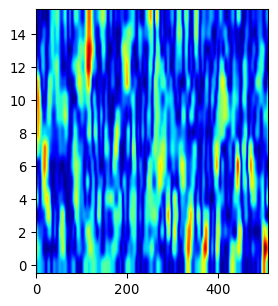

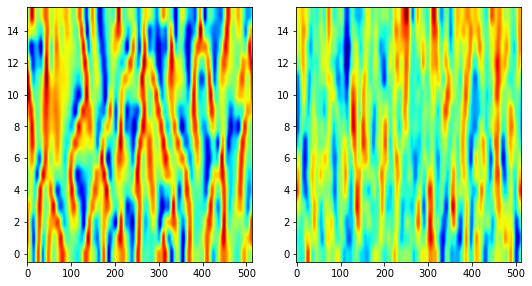

In [3]:
error = np.zeros(ypred.shape)

y_values = y_graph[-ypred.shape[0]:]
print(y_values.shape, ypred.shape, error.shape)

error_norm = 0
Max = 0

for i in range(ypred.shape[0]):
    for j in range(ypred.shape[1]):
        error[i][j] = ((y_values[i][j] - ypred[i][j])**2)**(1/2)
        error_norm = + error[i][j]
        if error[i][j] > Max:
            Max = error[i][j]

print("Max = ", Max, "\n Error = ", error_norm/(ypred.shape[0]*ypred.shape[1]))            
plt.figure(figsize=(300/96,350/96), dpi=96)
plt.imshow(error, aspect='auto', cmap='jet' , origin='lower')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(850/96,450/96))
ax[0].imshow(y_values, aspect='auto', cmap='jet', origin='lower')

#ax[1].figure(figsize=(300/96,350/96), dpi=96)
im = ax[1].imshow(ypred, aspect='auto', cmap='jet', origin='lower')

plt.savefig('puerba2')
#fig.colorbar(im, ax=ax[1])
#plt.savefig('puerba5')
plt.show()
